## Description

This notebook calculates the probability that a second endurance run has lower underlying failure rate than the first one. As input, we need two test runs results with `duration_1` `n_fails_1` `duration_2` `n_fails_2`. The calcation is based on a uniform prior and the assumption that the results of run1 and run2 are statistically independent and that the failure rates within each run are constant.

Typically, this question arises when the number of failures during run2 was lower than in run1, i.e. when `n_fails_2/duration_2 <= n_fails_1/duration_1`.
When faced with test results, the calculations tell you how often you should expect the test results in run2 to look better than in run1 despite the underlying failure rates (which you would get for infinitely long runs) being actually worse in run2. 

Note: all probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.

## Parameters

In [80]:
duration_1 = 10 #duration of 1st endurance run
n_fails_1 = 3 #number of fails in 1st endurance runs
duration_2 = 10 #duration of 2nd endurance run
n_fails_2 = 2 #number of fails in in 2nd endurance runs

round_to_digits = 4

## Evaluation

In [99]:
from sympy import *
import numpy as np

def L1_(lam):
    prior = lambda lam: 1
    # We do not need the factor of `1/factorial(n_fails_1)` because L1 below gets normalized and
    # the factor does not depend on lam.
    return (lam*duration_1)**n_fails_1 * exp(-(lam*duration_1)) * prior(lam)
def L2_(lam):
    prior = lambda lam: 1
    return (lam*duration_2)**n_fails_2 * exp(-(lam*duration_2)) * prior(lam)
def L1(lam): # normalized, integral over lam is 1
    norm = integrate(L1_(lam), (lam,0,oo))
    return L1_(lam) / norm
def L2(lam):
    norm = integrate(L2_(lam), (lam,0,oo))
    return L2_(lam) / norm

lam1, lam2 = symbols('lam1 lam2', real=True, positive=True)

def P_product(lam1, lam2): # assuming statistically independent endurance runs here.
    return L1(lam1) * L2(lam2)

Pprod_given = simplify(P_product(lam1,lam2))
print(Pprod_given)

2500000*lam1**3*lam2**2*exp(-10*lam1 - 10*lam2)/3


In [100]:
int_0_lam1 = simplify(integrate(Pprod_given,(lam2,0,lam1)))
P_getResultsVialam2ltlam1 = integrate(int_0_lam1, (lam1,0,oo))

print(f'You have conducted two test endurance runs. The first one had {n_fails_1} fails during {duration_1} time units, the second one had {n_fails_2} fails during {duration_2} time units.')
print(f'Using the assumptions, the probability is {1-round(P_getResultsVialam2ltlam1.evalf(), round_to_digits)} to get the given test result even if the underlying failure rate of endurance run2 is higher than that of run1.')
print(f'Thus, we are {round(P_getResultsVialam2ltlam1.evalf(), round_to_digits)} confident that endurance run2 has a lower failure rate.')

You have conducted two test endurance runs. The first one had 3 fails during 10 time units, the second one had 2 fails during 10 time units.
Using the assumptions, the probability is 0.3438 to get the given test result even if the underlying failure rate of endurance run2 is higher than that of run1.
Thus, we are 0.6562 confident that endurance run2 has a lower failure rate.


Plotted in green is the diagonal.
Above the diagonal is where failure_rate_1 is lower than failure_rate_2 and still the results turn out like the the given endurance results.


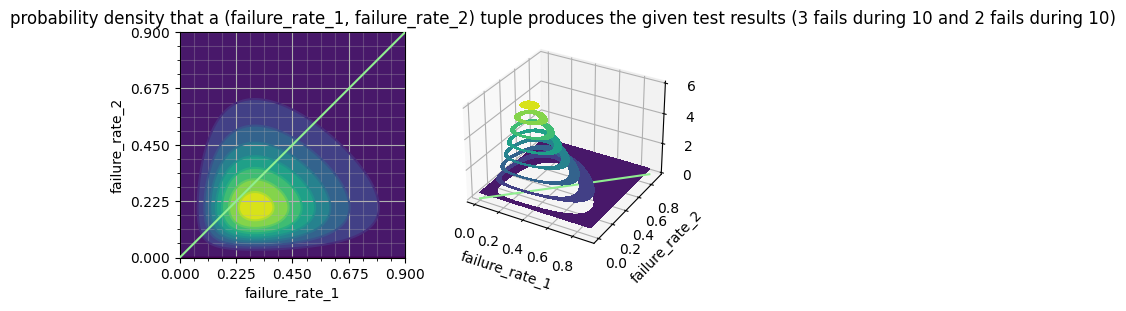

In [101]:
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify

#t1, t2 = symbols('t1 t2', real=True, positive=True) # 1/lam as mean time between fail 
#Pprod_given_ = Pprod_given.subs(lam1, 1/t1).subs(lam2, 1/t2)
#print(Pprod_given_)
#fxy = np.vectorize(lambdify([t1,t2], Pprod_given_))

fxy = np.vectorize(lambdify([lam1,lam2], Pprod_given))

range_lo = 0.0 # adapt plot range here ..
range_hi = 0.9 # .. and adapt here too (failure rates can go beyond 1.0 per time)
xx, yy = np.meshgrid(np.linspace(range_lo, range_hi, 101), np.linspace(range_lo, range_hi, 101))
zz = fxy(xx,yy)

fig = plt.figure()

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal') # only available in 2D
ax.set_xlabel("failure_rate_1"); ax.set_ylabel("failure_rate_2"); 
ax.plot([range_lo,range_hi],[range_lo,range_hi], color='lightgreen',zorder=3)

c = ax.contourf(xx, yy, zz)
c = ax.contour(xx, yy, zz)
#ax.clabel(c, c.levels, inline=True, colors="c")
plt.gca().set_xticks(np.linspace(range_lo, range_hi, 5), minor=False)
plt.gca().set_yticks(np.linspace(range_lo, range_hi, 5), minor=False)
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().tick_params(axis='y', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);


ax3 = fig.add_subplot(1,2,2, projection='3d')
ax3.set_xlabel("failure_rate_1"); ax3.set_ylabel("failure_rate_2"); 
ax3.set_title(f'probability density that a (failure_rate_1, failure_rate_2) tuple produces the given test results ({n_fails_1} fails during {duration_1} and {n_fails_2} fails during {duration_2})')
ax3.contourf(xx, yy, zz)
ax3.plot([range_lo,range_hi],[range_lo,range_hi], color='lightgreen',zorder=3)

print("Plotted in green is the diagonal.")
print("Above the diagonal is where failure_rate_1 is lower than failure_rate_2 and still the results turn out like the the given endurance results.")

## Summary

In [102]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

assert n_fails_2/duration_2 <= n_fails_1/duration_1, 'The summary text below is written assuming n_fails_2/duration_2 <= n_fails_1/duration_1' 

In [103]:
printmd(f"Your improved indurance test results **can happen by luck** in **{round(1-P_getResultsVialam2ltlam1.evalf(), round_to_digits)*100}%**" + \
        f" of similar endurance runs **even when the actual failure rates are equal or worse in the endurance run2**.") 


Your improved indurance test results **can happen by luck** in **34.38%** of similar endurance runs **even when the actual failure rates are equal or worse in the endurance run2**.

#### Bonus: similar to above but via numerical integration.

In [104]:
# similar to above but via numerical integration.
# just for future reference.
import numpy as np
from scipy.integrate import quadrature

quasi_inf = 10*max(n_fails_1/duration_1,n_fails_2/duration_2)
print(quasi_inf)

fxy = np.vectorize(lambdify([lam1,lam2], Pprod_given))
# def fxy(x,y):
#     return x**y

# Perform the first integration with respect to x
def integrand_x(x, y):
    return fxy(x, y)

# Use quadrature to integrate with respect to x from y to inf with a fixed y
def integrate_x(y):
    result, error = quadrature(integrand_x, y, quasi_inf, args=(y,))
    #result, error = scipy.integrate.quad(integrand_x, y, 100, args=(y,))
    #print(f'{error=}')
    return result

# Perform the second integration with respect to y
def integrand_y(y):
    return np.vectorize(integrate_x)(y)

# Use quadrature to integrate with respect to y from 0 to inf
result, error = quadrature(integrand_y, 0, quasi_inf)
#result, error = scipy.integrate.quad(integrand_y, 0, 1) ## buggy in pyodide 

result, error

3.0


(0.6562499999335847, 3.565339357081143e-09)

In [107]:
numerical_error = P_getResultsVialam2ltlam1.evalf() - result
numerical_error 

6.64153176899163e-11